In [1]:
import torch
from torch import nn
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [94]:
inception_model = models.googlenet(pretrained=True)

In [131]:
inception_model = models.vgg19(pretrained=True)

In [132]:
list(inception_model.features.named_children())

[('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('1', ReLU(inplace)),
 ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('3', ReLU(inplace)),
 ('4',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('6', ReLU(inplace)),
 ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('8', ReLU(inplace)),
 ('9',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('11', ReLU(inplace)),
 ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('13', ReLU(inplace)),
 ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('15', ReLU(inplace)),
 ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('17', ReLU(inplace)),
 ('18',
  MaxPool2d(kernel

In [103]:
def get(s,i):
    if isinstance(i, int):
        return list(s.children())[i]
    elif isinstance(i, str):
        layers = i.split("/")
        l = s
        for layer in layers:
            l = getattr(l, layer)
        return l

nn.Module.__getitem__ = get

In [118]:
from src.hooks import Hook

class CutModel():
    def __init__(self, model, layer, channel):
        self.model,self.layer,self.channel=model,layer,channel
        self.active = False
        for p in self.model.parameters():
            p.requires_grad_(False)
        
    def __call__(self, x):
        def activation_fn(module,input,output):
            self.loss = -torch.mean(output[:,self.channel])
            self.active = True
            
        with Hook(self.model[self.layer], activation_fn, detach=False):
            for i,m in enumerate(self.model.children()):
                x = m(x)
                if self.active:
                    self.active = False
                    break
        return x

In [157]:
model = CutModel(inception_model.features, 16, 222)

In [158]:
def random_im(size=64):
    im = torch.rand((3,size,size))*30 + 160
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    im /= 255
    im -= mean[..., None, None]
    im /= std[..., None, None]
    im.unsqueeze_(0)
    im.requires_grad_(True)
    return im

In [159]:
im = random_im()
im.requires_grad

True

In [160]:
def norm(im):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    im /= 255
    im -= mean[..., None, None]
    im /= std[..., None, None]
    im.unsqueeze_(0)
    im.requires_grad_(True)
    return im

In [161]:
from PIL import Image

def denorm(im):
    im = im.detach().clone().cpu().squeeze()
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    im *= std[..., None, None]
    im += mean[..., None, None]
    im *= 254
    im += 0.5
    im = im.permute(1,2,0).numpy()
    im[im>255]=255
    im[im<0]=0
    
    im = Image.fromarray(im.round().astype('uint8'))
    return im

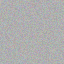

In [162]:
denorm(im)

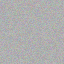

In [163]:
ITERS = 60

input_img = random_im()
optim = torch.optim.Adam([input_img], lr=0.05, weight_decay=1e-6)
denorm(input_img)

In [164]:
import torchvision
from src.transforms import Blur

tfms = torchvision.transforms.Compose([
    torchvision.transforms.RandomApply([Blur(2)], p=0.5),
#     torchvision.transforms.ToPILImage(),
#     torchvision.transforms.RandomRotation(10),
#     torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
# #     torchvision.transforms.Pad(2, padding_mode='reflect'),
#     torchvision.transforms.ToTensor()
])

In [165]:
# device = torch.device("cuda:0")
# model.model.to(device)
# input_img.to(device)

In [166]:
from IPython.display import display

In [167]:
def zoom(im, zoom=2):
    return im.transform((int(im.size[0]*zoom), int(im.size[1]*zoom)), Image.EXTENT, (0, 0, im.size[0], im.size[1]))

0 3.5559282302856445


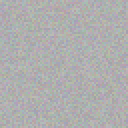

10 -29.574329376220703


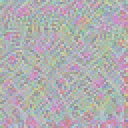

20 -49.868682861328125


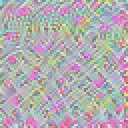

30 -67.11405944824219


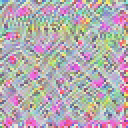

40 -81.73402404785156


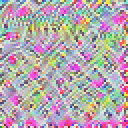

50 -95.59170532226562


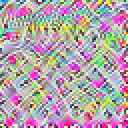

CPU times: user 11.5 s, sys: 4.22 s, total: 15.7 s
Wall time: 2.27 s


In [168]:
%%time

TRANSFORM = False

for i in range(ITERS):
    model(input_img)
    model.loss.backward()
    
    if i % 10 == 0:
        print(i, model.loss.item())
        display(zoom(denorm(input_img)))
    
    if TRANSFORM and i % 6 == 0:
        with torch.no_grad():
            input_img = tfms(input_img)
#         input_img = input_img.unsqueeze(0)            
        input_img.requires_grad_(True)
    
        
    optim.step()
    optim.zero_grad()
    input_img.data.clamp_(-2,2)

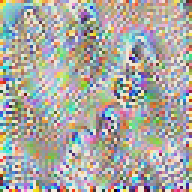

In [21]:
zoom(denorm(input_img), 3) #.crop((a.size[0]/2, a.size[1]/2, 3*a.size[0]/2, 3*a.size[1]/2))

In [287]:
from src import transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [289]:
tfms = transforms.get_transforms(224, mean, std)

In [318]:
a = Image.open('dog.jpg')
x = tfms(a)
y=inception_model(x)
print(y.argmax(0))


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 3, but got 3-dimensional input of size [3, 224, 224] instead

In [45]:
import torchvision

In [ ]:
a = Image.open('dog.jpg')

tfm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Blur(3),
    torchvision.transforms.ToPILImage()
])

In [317]:
%%timeit
tfm(a)

6.81 ms ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
class Blur():
    def __init__(self, kernel_size, variance=1., mean=1.):
        channels=3
        self.filter = nn.Conv2d(channels,channels,kernel_size, bias=False, groups=channels)
        kernel = torch.ones((channels,1,kernel_size,kernel_size))/(kernel_size*kernel_size)

        self.filter.weight.data = kernel
        self.filter.weight.requires_grad_(False)

    def __call__(self, x):
        if x.dim() == 3:
            x.unsqueeze_(0)
        return self.filter(x)

In [280]:
inception_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d